In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#! kaggle competitions download aptos2019-blindness-detection

Environment setup and loading of data

In [1]:
# load dependencies

# misc
import datetime
import os, sys, shutil

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm

# charting
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers, applications
from tensorflow.keras.applications import VGG19
from keras import layers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import models
from keras.models import Model
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50

In [5]:
# set file path variables
train_path = '/content/drive/MyDrive/DiabeticRetinopathy/train_images/'
test_path = '/content/drive/MyDrive/DiabeticRetinopathy/test_images/'

In [6]:
# load csv files with image file names and labels as pandas dataframes
train_data = pd.read_csv('/content/drive/MyDrive/DiabeticRetinopathy/train1.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DiabeticRetinopathy/test1.csv')

Initial EDA

In [4]:
# look at training data
train_data.head()

,id_code,diagnosis
0,f361060eda3e,0
1,d1fa0f744620,0
2,bcd503c726ba,4
3,70d657f8f503,4
4,a04fb36db784,2


In [5]:
# look at test data
test_data.head()

,id_code
0,f7dd2700a3d5
1,8a2b969112a7
2,1de193623108
3,bab03e16c029
4,659f752cb810


In [6]:
# number of images in test & train data
print('Number of images in training set is {}'.format(len(train_data)))
print('Number of images in test set is {}'.format(len(test_data)))

Number of images in training set is 1831
Number of images in test set is 964


In [7]:
# store the class information in some variables for convenience
class_labels = [0,1,2,3,4]
class_dict = {0:'No DR', 1:'Mild DR', 2:'Moderate DR', 3:'Severe DR', 4:'Proliferative DR'}
class_list = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

In [8]:
# look at the distribution of the training data into the 5 classes
train_data.diagnosis.value_counts()

0    898
2    492
1    181
4    150
3    110
Name: diagnosis, dtype: int64

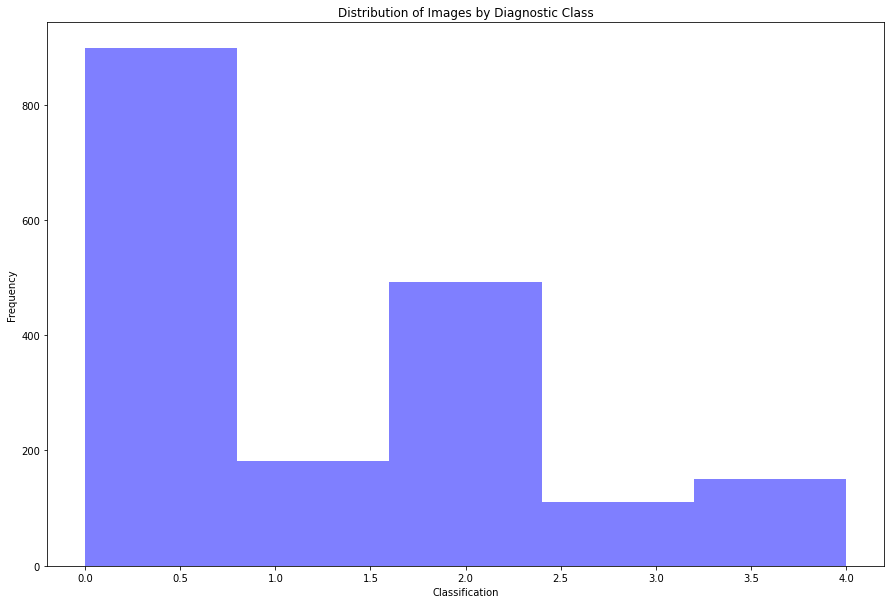

In [9]:
# plot the distribution of images by class
fig, ax = plt.subplots(1, 1, figsize=(15,10))

plt.hist(train_data.diagnosis, 5, facecolor='blue', alpha=0.5)

plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title(r'Distribution of Images by Diagnostic Class')
plt.show()

The training data is not balanced which is typical of disease related datasets, . Class 0 has by far the highest frequency and classes 3 and 4, the most serious from a disease perspective, are in relatively small proportions. In theory (given sufficient data) convolutional neural networks do not need balanced data to perform well. I did not utilize any methods to balance the classes but this an area that could be explored in the future if the model's performance is not good enough.

In [10]:
# function to show some images

def show_15_images(df, category):
    # category is 0, 1, 2, 3, 4
    rows = 3
    columns = 5
    fig, ax = plt.subplots(rows, columns, figsize=(15,10))
    
    title = class_list[category]
    images = df[df['diagnosis'] == category][:15].id_code.values
    
    for sample in range (0, 15):
        image = Image.open(os.path.join(train_path, images[sample] + '.png'))
        
        col = sample // columns
        row = sample % columns
        ax[col, row].imshow(image)
        ax[col, row].axis('off')
    
    plt.suptitle(title)
    plt.show()

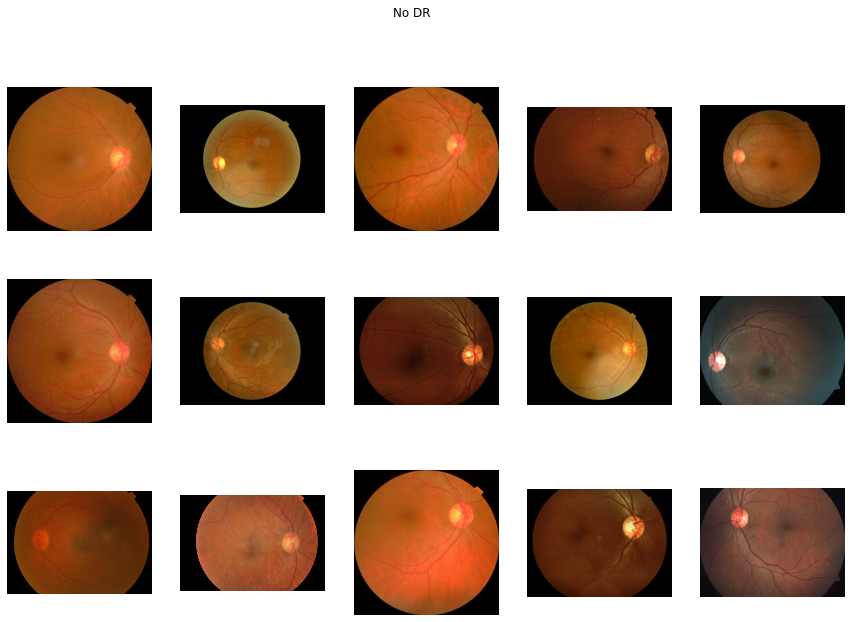

In [11]:
# look at some class 0 images
show_15_images(train_data, 0)

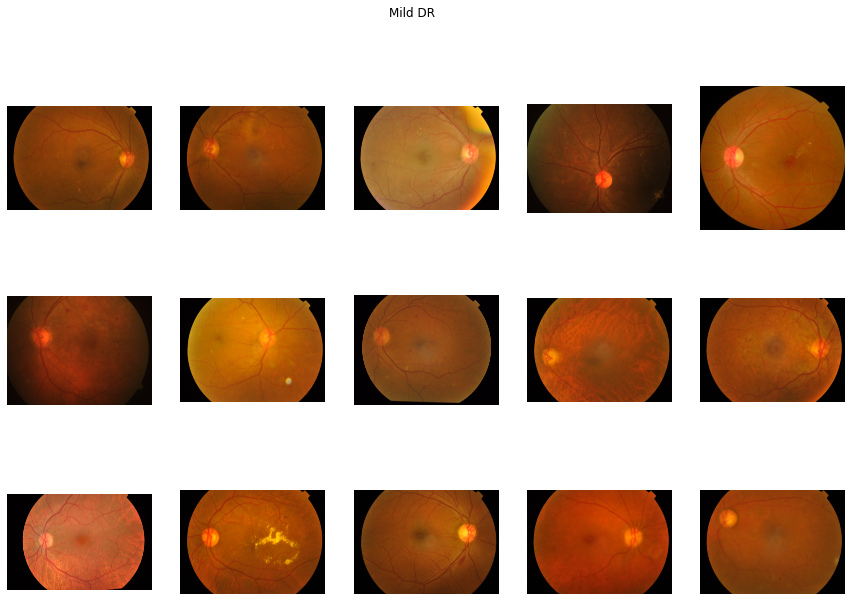

In [12]:
# look at some class 1 images
show_15_images(train_data, 1)

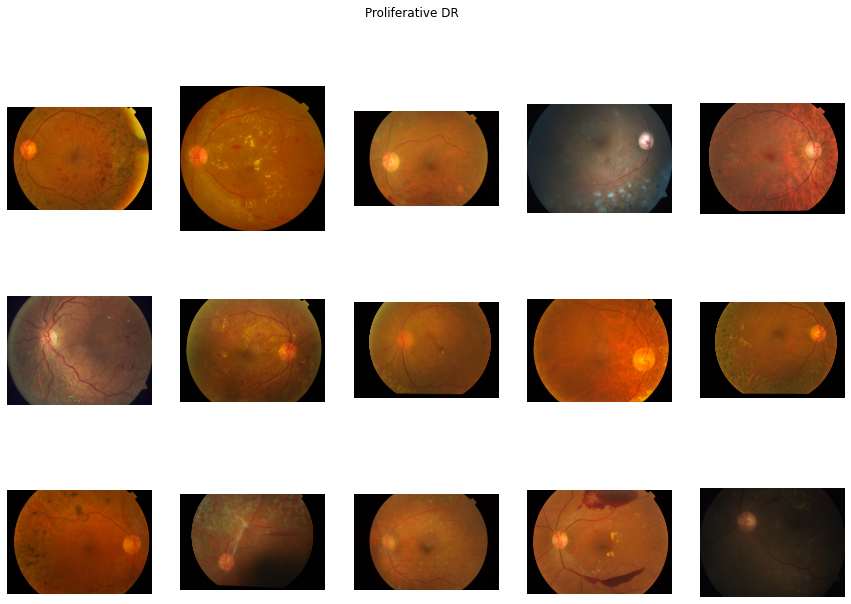

In [13]:
# look at some class 4 images
show_15_images(train_data, 4)

The images vary in dimensions, contrast, brightness, and orientation. Additionally, the images have varying amounts of black wsurrounding the circular image of the retina. If this black area is correlated with the class value this could be a problem, as the CNN will learn to predict based on the black area, which is obviously not what I want the model to be looking at. Time permitting I will attempt to investigate this further and try some methods to reduce the effect of the black areas.

In [14]:
# function to determine largest and smallest dimensions of the images
def get_dimensions(df, path):
    max_width = 0
    max_height = 0
    min_width = 0
    max_height = 0
    
    file_names = df['id_code']
    
    for index, file_name in enumerate(file_names):
        current_image = Image.open(os.path.join(path, file_name + '.png'))

        width, height = current_image.size
        
        # set initial values
        if max_width == 0:
            max_width = width
            min_width = width
            max_height = height
            min_height = height
        
        if width > max_width:
            max_width = width
        if width < min_width:
            min_width = width
            
        if height > max_height:
            max_height = height
        if height < min_height:
            min_height = height
    
    print('Minimum width: {},'.format(min_width))
    print('Maximum width: {},'.format(max_width))
    print('************')
    print('Minimum height: {}'.format(min_height))
    print('Maximum height: {}'.format(max_height))

In [15]:
# look at the train images sizes
get_dimensions(train_data, train_path)

Minimum width: 474,
Maximum width: 4288,
************
Minimum height: 358
Maximum height: 2848


In [16]:
# look at the test images sizes
get_dimensions(test_data, test_path)

Minimum width: 640,
Maximum width: 2896,
************
Minimum height: 480
Maximum height: 1958


In [17]:
# create new directories for the split of images into training, validation, and testing


old_train = train_path
new_folder = '/content/drive/MyDrive/DiabeticRetinopathy/data_organized'

dir_names = ['train', 'val', 'test']

os.mkdir(new_folder)

for d in dir_names:
  new_dir = os.path.join(new_folder, d)
  os.mkdir(new_dir)

In [18]:
# copy the images in the the three folders


for label in class_labels:
  print('Moving Class {} images.'.format(label))
  for d in dir_names:
    new_dir = os.path.join(new_folder, d, str(label))
    os.mkdir(new_dir)
  temp = train_data[train_data.diagnosis == label]
  train, validate, test = np.split(temp.sample(frac=1), [int(.8*len(temp)), int(.9*len(temp))])
  print('Split {} imgs into {} train, {} val, and {} test examples.'.format(len(temp),len(train),len(validate),len(test)))
  for i, temp in enumerate([train, validate, test]):
    for row in temp.index:
      filename = temp['id_code'][row] + '.png'
      origin = os.path.join(old_train + '/' + filename)
      destination = os.path.join(new_folder + '/' + dir_names[i] + '/' + str(label) + '/' + filename)
      shutil.copy(origin, destination)

Moving Class 0 images.
Split 898 imgs into 718 train, 90 val, and 90 test examples.
Moving Class 1 images.
Split 181 imgs into 144 train, 18 val, and 19 test examples.
Moving Class 2 images.
Split 492 imgs into 393 train, 49 val, and 50 test examples.
Moving Class 3 images.
Split 110 imgs into 88 train, 11 val, and 11 test examples.
Moving Class 4 images.
Split 150 imgs into 120 train, 15 val, and 15 test examples.


In [19]:
# set new paths to the directories
train_dir = '/content/drive/MyDrive/DiabeticRetinopathy/data_organized/train/'
validation_dir = '/content/drive/MyDrive/DiabeticRetinopathy/data_organized/val/'
test_dir = '/content/drive/MyDrive/DiabeticRetinopathy/data_organized/test/'

In [20]:
# count the images in each directory
def count_images(path):
    count = 0
    for directory in os.listdir(path):
        count += len(os.listdir(path + "/" + directory))
    return count

In [21]:
total_train = count_images(train_dir)
total_train

1463

In [22]:
total_val = count_images(validation_dir)
total_val

183

In [23]:
total_test = count_images(test_dir)
total_test

185

In [25]:
# CNN model parameters
BATCH_SIZE = 32
EPOCHS = 10  #this take over 8 hours to run, early stopping trials ended at about 6 epochs
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 128
WIDTH = 128
COLORS = 3
N_CLASSES = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [26]:
# get all the images in the training directory and reshape and augment them
train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=20,
#       width_shift_range=0.2,   # removed these for time savings
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(HEIGHT, WIDTH), 
        batch_size= BATCH_SIZE,
        shuffle = True,
        class_mode= 'categorical') 


# get all the data in the validation directory and reshape them
val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(
        validation_dir, 
        target_size=(HEIGHT, WIDTH),
        batch_size = BATCH_SIZE,
        class_mode= 'categorical')

# get all the data in the test directory and reshape them
test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
        test_dir, 
        target_size=(HEIGHT, WIDTH), 
        batch_size = 1,
        class_mode= 'categorical',
        shuffle = False)

Found 1463 images belonging to 5 classes.
Found 183 images belonging to 5 classes.
Found 185 images belonging to 5 classes.


In [41]:
# created a function to create models - all using ResNet50 weights
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [44]:
# instantiate and compile a model
model = create_model(input_shape=(HEIGHT, WIDTH, COLORS), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [45]:
# warm up training phase, only two epochs
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/2
45/45 [==============================] - 248s 5s/step - loss: 1.5433 - accuracy: 0.4018 - val_loss: 1.2511 - val_accuracy: 0.4812
Epoch 2/2
45/45 [==============================] - 194s 4s/step - loss: 1.3995 - accuracy: 0.4633 - val_loss: 1.1365 - val_accuracy: 0.5188


In [46]:
# create the model, use early stopping
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [47]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [52]:
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
45/45 [==============================] - 196s 4s/step - loss: 0.2013 - accuracy: 0.7890 - val_loss: 0.7596 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 2/10
45/45 [==============================] - 187s 4s/step - loss: 0.1881 - accuracy: 0.7980 - val_loss: 0.6590 - val_accuracy: 0.1000 - lr: 1.0000e-04
Epoch 3/10
45/45 [==============================] - 189s 4s/step - loss: 0.1717 - accuracy: 0.8260 - val_loss: 0.6728 - val_accuracy: 0.4250 - lr: 1.0000e-04
Epoch 4/10
45/45 [==============================] - 187s 4s/step - loss: 0.1577 - accuracy: 0.8344 - val_loss: 0.6825 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 5/10
45/45 [==============================] - 187s 4s/step - loss: 0.1396 - accuracy: 0.8602 - val_loss: 0.5833 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/10
45/45 [==============================] - 188s 4s/step - loss: 0.1289 - accuracy: 0.8721 - val_loss: 0.6999 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/10
45/45 [==============================] - 

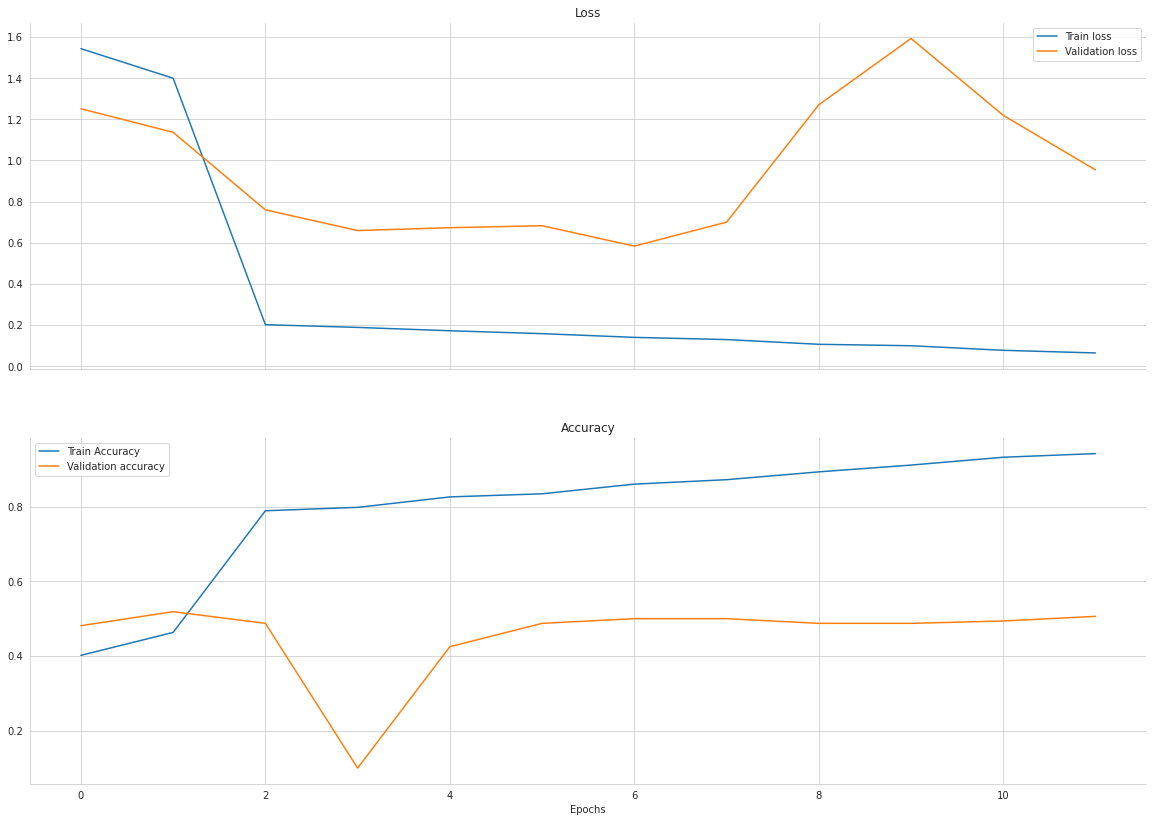

In [53]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [54]:
# save the model

model.save('/content/drive/MyDrive/DiabeticRetinopathy/ResNet50_91_3.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model's predictions for all of the train images

In [2]:
model = load_model('/content/drive/MyDrive/DiabeticRetinopathy/ResNet50_91_3.h5')

In [3]:
# function to make a tensor of an image
def preprocess_image(image_path, desired_size=128):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [7]:
# make tensors of all of the training images
N = train_data.shape[0]

x_train = np.empty((N, 128, 128, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_data['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        os.path.join(train_path + "/" + image_id + '.png')
    )

100%|██████████| 1831/1831 [13:50<00:00,  2.20it/s]


In [8]:
# make all of the values in the tensor on a scale of 0 to 1
x_train = x_train/255

In [9]:
# use the model to generate predictions for all of the training images
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

train_prediction = model.predict([x_train])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

Started predicting at 2022-02-12 17:19:26.709117
Predicting took a total of 0:01:28.640012


In [10]:
# look at the predictions, 5 probabilities, one for each class (0,1,2,3,4), for each image
train_prediction

array([[9.99957919e-01, 2.93584299e-06, 6.04081470e-06, 7.10421546e-06,
        2.58476048e-05],
       [9.99994874e-01, 1.06120105e-07, 8.48863294e-07, 1.57987461e-06,
        2.65546851e-06],
       [9.99005020e-01, 2.90492142e-04, 1.96163557e-04, 2.25484197e-04,
        2.82933324e-04],
       ...,
       [9.99725401e-01, 3.19275205e-05, 3.26803929e-05, 1.04954124e-04,
        1.05035826e-04],
       [9.99531150e-01, 6.33615491e-05, 6.67327040e-05, 1.53891713e-04,
        1.84803255e-04],
       [9.99480069e-01, 1.25654929e-04, 1.07555868e-04, 1.24682774e-04,
        1.62030599e-04]], dtype=float32)

In [17]:
# take the highest predicted probability for each image
train_predictions = [np.argmax(pred) for pred in train_prediction]

[2.9358321e-06 6.0407924e-06 7.1042291e-06 2.5847583e-05 9.9995804e-01]
[9.9999487e-01 1.0612052e-07 8.4886659e-07 1.5798731e-06 2.6554885e-06]
[9.9900490e-01 2.9048877e-04 1.9616201e-04 2.2548265e-04 2.8293164e-04]
[9.9991131e-01 6.6190096e-06 1.6081043e-05 1.6334610e-05 4.9557199e-05]
[9.9983358e-01 1.0329079e-05 2.0788289e-05 6.8434572e-05 6.6741370e-05]
[9.9944276e-01 4.0273295e-05 6.0604059e-05 2.1180268e-04 2.4454459e-04]
[9.9945956e-01 7.4436823e-05 1.0536270e-04 1.9123842e-04 1.6941136e-04]
[9.9997127e-01 4.4742483e-06 4.7984149e-06 5.0743943e-06 1.4348830e-05]
[9.99415040e-01 1.22520971e-04 1.20041695e-04 1.35546186e-04
 2.06931378e-04]
[9.9931395e-01 3.1995900e-05 1.2690869e-04 2.4505184e-04 2.8212962e-04]
[9.9948382e-01 8.9696594e-05 8.6197295e-05 1.8986921e-04 1.5032802e-04]
[9.9993277e-01 1.1375805e-06 2.2744939e-06 4.6773523e-05 1.7049339e-05]
[9.9961722e-01 7.6417637e-05 9.0489091e-05 1.1199089e-04 1.0394344e-04]
[9.9985003e-01 1.2893651e-06 1.7482483e-06 6.0180522e-05 8

In [15]:
#train_predictions = [list(pred).index(sorted(list(pred))[-2]) for pred in train_prediction]

In [ ]:
# look at how the model performed for each class
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_data['diagnosis'].astype('int'), train_predictions)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

Model's predictions for all of the test images

In [19]:
N = test_data.shape[0]

x_test = np.empty((N, 128, 128, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_data['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        os.path.join(test_path + "/" + image_id + '.png')
    )

100%|██████████| 964/964 [04:46<00:00,  3.37it/s]


In [20]:
x_test = x_test/255   # make values 0 to 1

In [21]:
# track the time
start = datetime.datetime.now()
print('Started predicting at {}'.format(start))

prediction = model.predict([x_test])

end = datetime.datetime.now()
elapsed = end - start
print('Predicting took a total of {}'.format(elapsed))

Started predicting at 2022-02-12 17:29:50.588025
Predicting took a total of 0:00:47.390131


In [22]:
prediction

array([[9.9988174e-01, 9.0356889e-06, 1.4950335e-05, 1.7015009e-05,
        7.7293465e-05],
       [9.9997067e-01, 3.3254084e-06, 4.2048050e-06, 5.8874580e-06,
        1.5975620e-05],
       [9.9949837e-01, 1.5702250e-05, 4.5640645e-05, 2.2600210e-04,
        2.1422646e-04],
       ...,
       [9.9797016e-01, 1.7009061e-05, 6.0234706e-05, 1.4242395e-03,
        5.2837771e-04],
       [9.9797958e-01, 4.7565438e-05, 9.9599805e-05, 7.0591690e-04,
        1.1672882e-03],
       [9.9584997e-01, 1.3429513e-04, 1.5687228e-03, 5.6713872e-04,
        1.8799888e-03]], dtype=float32)

Test on unknown image

In [23]:
# function to make a tensor of an image
def preprocess_image(image_path, desired_size=128):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [33]:
image = np.empty((1,128, 128, 3), dtype=np.uint8)
image[:,:,:] = preprocess_image('/content/sample_test.jpg')

In [34]:
image= image/255

In [35]:
prediction = model.predict([image])

In [36]:
prediction

array([[9.9998343e-01, 4.0211853e-07, 2.2200011e-06, 6.6653247e-06,
        7.2990956e-06]], dtype=float32)